<a href="https://colab.research.google.com/github/mikful/dlai-tf-in-practice/blob/master/TensorFlow_in_Practice_Course_4_S%2BP_Week_2_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


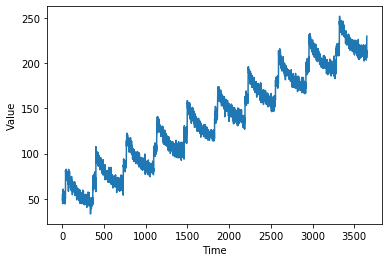

In [0]:
# Setup the data series and constants

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 0.6 * np.pi),
                    2 / np.exp(1.5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 12
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 4

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

# Split data at the split_time for train/valid sets
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Setup constants for the Single layer NN
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [0]:
# Function to create a windowed dataset
# Takes in a data series, window size and batch size and shuffle and creates a windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
# Create windowed dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Create Deep NN
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(20, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa

# lr_schedule = ExponentialCyclicalLearningRate(
#     initial_learning_rate=1e-4,
#     maximal_learning_rate=1e-2,
#     step_size=2000,
#     scale_mode="cycle",
#     gamma=0.96,
#     name="MyCyclicScheduler")


opt = tf.keras.optimizers.Adam()
opt = tfa.optimizers.Lookahead(opt)

model.compile(loss='mse', optimizer=opt)
model.fit(dataset,epochs=100,verbose=1)


Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94/94 [==============================] - 4s 38ms/step - loss: 759.8463
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 55.9879
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 56.0664
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 53.4573
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 54.5827
Epoch 6/100
94/94 [==============================] - 1s 7ms/step - loss: 50.9878
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 49.4454
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 48.0716
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 46.7443
Epoch 10/100
94/94 [==============================] - 1s 7ms/step - loss: 45.3895
Epoch 11/100
94/94 [==============================] - 1s 6ms/step - loss: 44.2474
Epoch 12/100
94/94 [====

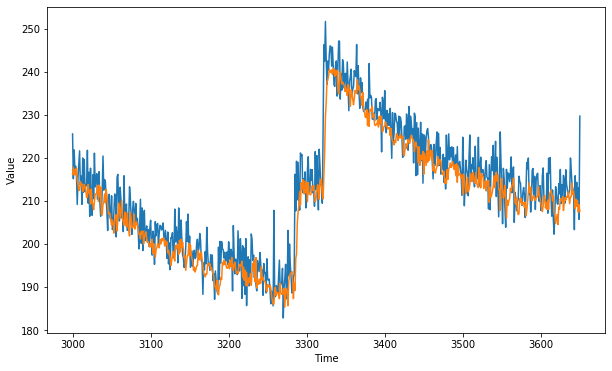

In [0]:
# Predict the next values

forecast = []

# Iterate over the data by passing in a window size of data and predicting the next value
# Do a standard linear regression to get the result: Y = W0*X0 +.... W19*X19 + b
# add to list
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# As data was split into train/valid, take the valid data after the split time to forecast it
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# plot series
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

4.2227807